# Using the land-sea mask

In this example, it is shown how to use a land-sea mask. The land-sea mask is extracting from the variable : `ocean_fraction_surface`. Throughout these exercises we will use the land-sea mask to plot a spatial map of precipitation over land (**section 1**), a probability density function of precipitation over the tropics, tropical land and tropical ocean (**section 2**). The diurnal cycle of precipitation is also calculated over South America and over the Indo-Pacific (**section 3**)  


**Functions to take into account** <br>
`attach_coords` attaches coordinates to HEALPix data <br>
`hpmap` plots color shading maps of HEALPix data with attached coordinates using data-shader <br>
`d_cycle` calculate the diurnal cycle.

### Calling packages

In [1]:
import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import datashader as ds
import datashader.transfer_functions as tf
from datashader.mpl_ext import dsshow


### Defining functions

In [2]:
def get_nest(ds):
    return ds.crs.healpix_order == "nest"

def get_nside(ds):
    return ds.crs.healpix_nside

def attach_coords(ds):
    lons, lats = hp.pix2ang(get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True)
    return ds.assign_coords(
        lat = (("cell",), lats, {"units": "degree_north"}),
        lon = (("cell",), lons, {"units": "degree_east"}),
    )

def hpmap(fld, projection, fig, ax, thrx=1, mp=1, **kwargs):
    """
    Uses datashader to quickly render a dense spatial field form the cartopy projection
    
    fld: a one dimensional list of cells with an associated longitud and latitude for each
    projection: a cartopy map projection for the plot
    thrx: theshold for pixelizaiton
    mp: maximum number of neighboring pizels
    kwargs: additional arguments to dsshow
    """  

    fig.canvas.draw_idle() 
    cx     = projection.transform_points(ccrs.Geodetic(),fld.lon,fld.lat)
    df     = pd.DataFrame(data = {"val" : np.squeeze(fld), "lon" : cx[:,0], "lat" : cx[:,1]})
    artist = dsshow(df, ds.Point('lon','lat'), ds.mean('val')
                    , shade_hook=lambda img: tf.dynspread(img, threshold=thrx, max_px=mp, shape="square")
                    , ax=ax, **kwargs)
    return artist

def read_dataset(catalog,model_name,exp_name='ngc3028',zoom=5,time_resolution="P1D"):
    ### catalog: catalog of the simulations
    ### exp_name: name of the experiment (ngc3026 and ngc3028)
    ### zoom: the resolution of the simulation from 1 (coarse resolution) to 10 (high resolution)
    ### time step: PT30M (30 minutes),PT3H (3 hours), P1D (daily)
    exp = catalog[model_name][exp_name](time=time_resolution, zoom=zoom, chunks="auto").to_dask()
    return attach_coords(exp)


####calculating PDF
def histograms_bins(fld,bins):
    counts_per_bin, bin_edges = np.histogram(fld, bins,density=True)
    return counts_per_bin, bin_edges

####calculating diurnal cycle
def d_cycle(data):
    lhour = create_local_hour(data)
    dcycle = np.zeros((24,1))
    for t in range(24):
        dcycle[t,0] = data.where(lhour==t).mean(skipna=True)
    return dcycle

def create_local_hour(data):
    lon =  data.lon.where(data.lon<180,data.lon-360)
    lhour1 = (data*0 + data.hour + 24/360*lon).round()
    lhour2 = lhour1.where(lhour1>=0,lhour1+24)
    lhour3 = lhour2.where(lhour2<24,lhour2-24)
    return lhour3


In [3]:
domains = {
    "tropics": lambda ds: (ds["lat"] > -30.1) & (ds["lat"] < 30.0),
    "tropical ocean": lambda ds: (ds["lat"] > -30.1) & (ds["lat"] < 30.0) & (ds["ocean_fraction_surface"] == 1),
    "tropical land": lambda ds: (ds["lat"] > -30.1) & (ds["lat"] < 30.0) & (ds["ocean_fraction_surface"] == 0),
    "s.america": lambda ds: (
        ds["lat"] > -30.1) & (
        ds["lat"] < 10.0) & (
        ds["lon"] >= -280) & (
        ds["lat"] <= 330.0) &  (
        ds["ocean_fraction_surface"] == 0),
        "indo pacific": lambda ds: (
        ds["lat"] > -10.1) & (
        ds["lat"] < 10.0) & (
        ds["lon"] >= 80) & (
        ds["lat"] <= 150.0) &  (
        ds["ocean_fraction_surface"] == 1)
}

def cells_of_domain(ds, domain_name):
    return np.where(domains[domain_name](ds))[0]

### General settings 

In [4]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
var, model_name, exp_name = 'pr','ICON','ngc3028'
t1,t2 = '2020-02-01','2020-03-31'

#####transform pr units from kg m-2 s-1 to mm d-1
processing_properties = {
    "pr": dict(time_scale=86400),
    "default": dict(time_scale=1),
}

if var == 'pr':
    var_properties = 'pr'
else:
    var_properties = 'default'
    
###Projection to use
clon= -135.5808361
proj = ccrs.EqualEarth(central_longitude=clon)
##
sns.set_context('talk')##appereance of plots for talks

### Plotting settings 

In [5]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
def format_axes(ax,proj,xlim=[-180,180],ylim=[-90,90],deltax=30,deltay=15,axes=False,noproj=None):
    if axes==False:
        ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]],crs=proj)
        ax.spines.clear()
        ax.coastlines(color='black',lw=1)
    else:
        ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]],crs=proj)
        ax.set_yticks(np.arange(ylim[0],ylim[1]+1,deltay))
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_xticks(np.arange(xlim[0],xlim[1]-1,deltax), crs=noproj)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)

In [6]:
####Generating new colormap
GnBu = cm.get_cmap('YlGnBu', 12)
newcolors = GnBu(np.linspace(0, 1, 12))
white = np.array([1, 1, 1, 1]) #white color
scnd = np.array([0.89051745, 0.76469402, 0.71028506 , 1]) #brown color
newcolors[0, :] = white
newcolors[1, :] = scnd
clevs = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25,
         30, 35]
GnBu_new = ListedColormap(newcolors,'precip')
GnBu_new_norm = BoundaryNorm(clevs,GnBu_new.N)

### Section 1: Computing tropical land precipitation

In [7]:
%%time
ds_3028 = read_dataset(cat,model_name,exp_name=exp_name,zoom=6,time_resolution="P1D")
domain = 'tropical land'
pr_tropics_land = (
    ds_3028[var]
    .isel(cell=cells_of_domain(ds_3028, domain))
    .sel(time=slice(t1,t2)).mean('time')
    * processing_properties[var_properties]["time_scale"])

domain = 'tropical ocean'
pr_tropics_ocean = (
    ds_3028[var]
    .isel(cell=cells_of_domain(ds_3028, domain))
    .sel(time=slice(t1,t2)).mean('time')
    * processing_properties[var_properties]["time_scale"])

CPU times: user 673 ms, sys: 163 ms, total: 836 ms
Wall time: 1.33 s


CPU times: user 878 ms, sys: 243 ms, total: 1.12 s
Wall time: 2.7 s


Text(0.5, 1.0, 'ngc3028 Feb.2020- Mar.2020 - zoom=6 - Tropical land')

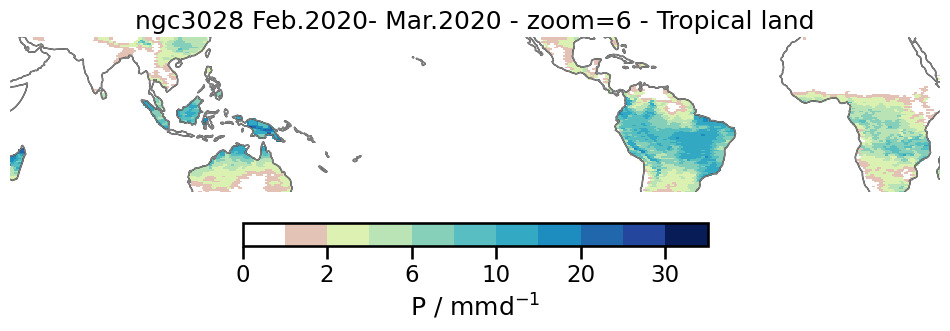

In [8]:
%%time
######
title         = f'{exp_name} Feb.2020- Mar.2020 - zoom=6 - Tropical land'
proj = ccrs.PlateCarree(central_longitude=clon)
fig, ax = plt.subplots(figsize=(12,8),facecolor='white',subplot_kw={"projection": proj})
artist  = hpmap(pr_tropics_land, proj, fig, ax, mp=2, cmap=GnBu_new, norm = GnBu_new_norm)
format_axes(ax,proj,xlim=[-180,180],ylim=[-30,30])
ax.coastlines(color='gray',lw=1)
fig.colorbar(artist, label='P / mmd$^{-1}$', shrink=0.5,orientation='horizontal',pad=0.05)
plt.title(title)

### Section 2: PDF of precipitation

In [10]:
%%time

t1,t2 = '2020-02-01','2021-01-31'
ds_3028 = read_dataset(cat,model_name,exp_name=exp_name,zoom=6,time_resolution="P1D")

domain = 'tropics'
pr_tropics = (
    ds_3028[var]
    .isel(cell=cells_of_domain(ds_3028, domain))
    .sel(time=slice(t1,t2))
    * processing_properties[var_properties]["time_scale"])

domain = 'tropical ocean'
pr_tropics_ocean = (
    ds_3028[var]
    .isel(cell=cells_of_domain(ds_3028, domain))
    .sel(time=slice(t1,t2))
    * processing_properties[var_properties]["time_scale"])

domain = 'tropical land'
pr_tropics_land = (
    ds_3028[var]
    .isel(cell=cells_of_domain(ds_3028, domain))
    .sel(time=slice(t1,t2))
    * processing_properties[var_properties]["time_scale"])

CPU times: user 124 ms, sys: 1.87 ms, total: 126 ms
Wall time: 128 ms


**Calculating histogram**

In [11]:
%%time
bins = [0,0.1,1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,125,150,175,200,225,250]
histogram_tropics = histograms_bins(pr_tropics,bins)

histogram_tropics_ocean = histograms_bins(pr_tropics_ocean,bins)

histogram_tropics_land = histograms_bins(pr_tropics_land,bins)

CPU times: user 2.37 s, sys: 586 ms, total: 2.96 s
Wall time: 3.34 s


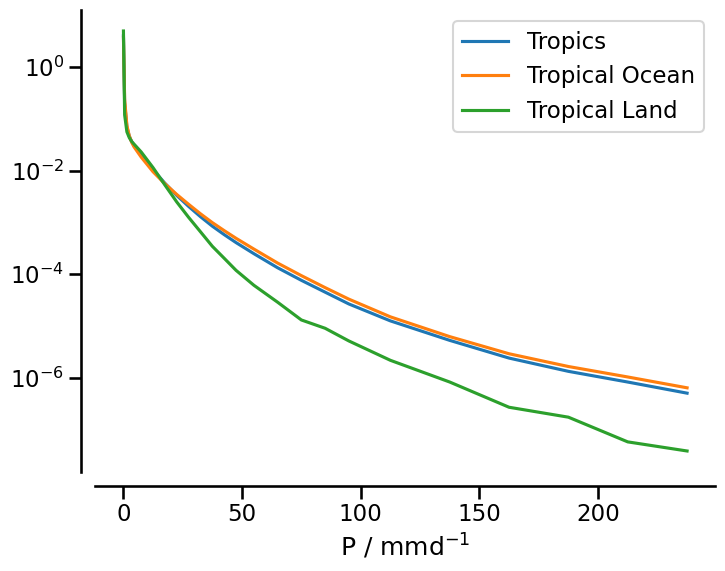

In [12]:
xaxis= (np.array(bins[1:]) - np.array(bins[:-1]))/2+np.array(bins[:-1])
fig = plt.figure(figsize=(8, 6),facecolor='white')
ax = fig.add_subplot(111)
plt.plot(xaxis,histogram_tropics[0],label='Tropics')
plt.plot(xaxis,histogram_tropics_ocean[0],label='Tropical Ocean')
plt.plot(xaxis,histogram_tropics_land[0],label='Tropical Land')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yscale('log')
ax.set_xlabel('P / mmd$^{-1}$')
sns.despine(offset = 10)
plt.legend()

### Section 3: Diurnal cycle of precipitation

For this example, we use data with a time step of 30 minutes to calculate the dirunal cycle of precipitation over two regions: South America and the Indo-Pacific. Because data with time step of 30 minutes do not have the variable`ocean_fraction_surface`, we use the daily output to extract this variable and add it to the 30 minutes time step.

In [13]:
%%time
t1,t2 = '2020-02-01','2020-02-29'

ds_3028_30min = read_dataset(cat,model_name,exp_name='ngc3028',zoom=6,time_resolution="PT30M").sel(
time=slice(t1,t2))

ls_mask = read_dataset(cat,model_name,exp_name='ngc3028',zoom=6,time_resolution="P1D").isel(
    time=0)["ocean_fraction_surface"]

ds_3028_30min = ds_3028_30min.assign(ocean_fraction_surface = ls_mask)

CPU times: user 182 ms, sys: 5.29 ms, total: 188 ms
Wall time: 213 ms


In [14]:
%%time
domain = 's.america'
pr_samerica_28= (
    ds_3028_30min[var]
    .isel(cell=cells_of_domain(ds_3028_30min, domain))
    .groupby('time.hour').mean()
    * processing_properties[var_properties]["time_scale"])

domain = 'indo pacific'
pr_indopacific_28= (
    ds_3028_30min[var]
    .isel(cell=cells_of_domain(ds_3028_30min, domain))
    .groupby('time.hour').mean()
    * processing_properties[var_properties]["time_scale"])


CPU times: user 100 ms, sys: 4.61 ms, total: 105 ms
Wall time: 106 ms


**Calculating diurnal cycle of precipitation**

In [15]:
%%time
dcycle_samerica_28 = d_cycle(pr_samerica_28)
dcycle_indopacific_28 = d_cycle(pr_indopacific_28)

CPU times: user 26.2 s, sys: 9.34 s, total: 35.5 s
Wall time: 15.2 s


In [18]:
def format_axes_time_series(ax,title):
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlabel('LST / hr')
    ax.set_ylabel('P / mmd$^{-1}$')
    ax.set_title(title)
    

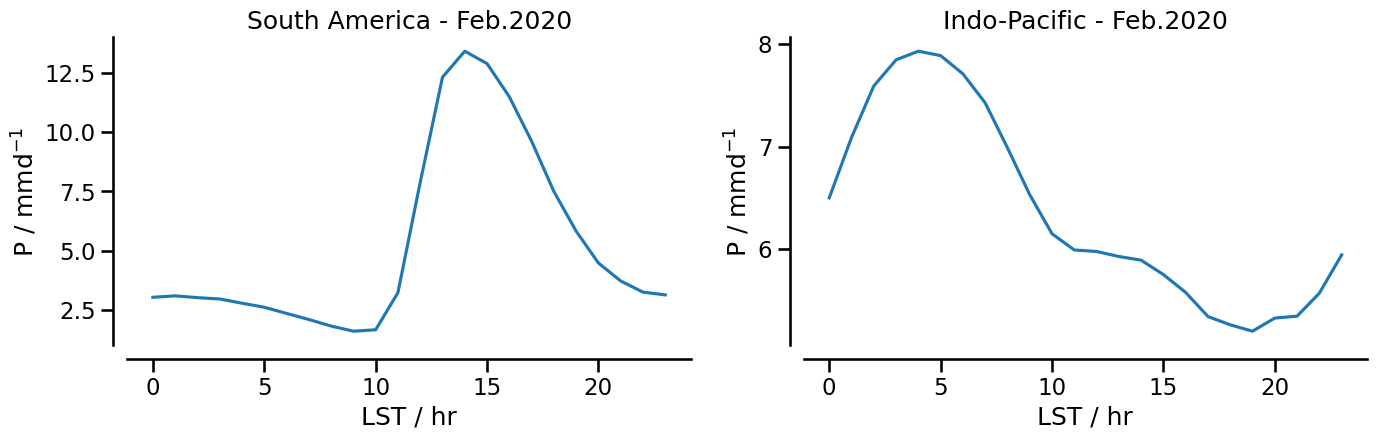

In [19]:
fig = plt.figure(figsize=(16, 4),facecolor='white')
ax = fig.add_subplot(121)
ax.plot(dcycle_samerica_28)
sns.despine(offset = 10)
format_axes_time_series(ax,title='South America - Feb.2020')

ax = fig.add_subplot(122)
ax.plot(dcycle_indopacific_28)
sns.despine(offset = 10)
format_axes_time_series(ax,title='Indo-Pacific - Feb.2020')
